# Challenge 2

### Initial datalog code

In [40]:
# (declare-rel inv (Int Int Int))
# (declare-var x Int)
# (declare-var x1 Int)
# (declare-var y Int)
# (declare-var y1 Int)
# (declare-var len Int)

# (declare-rel fail ())

# (rule (=>
#     (and (= x 0) (= y 0) (>= len 0)) (inv x y len)
#   )
# )

# (rule (=> 
#     (and 
# 	(inv x y len)
#         (< x len)
# 	(= x1 (+ x 1))
# 	(= y1 (+ y 2))
#     )
#     (inv x1 y1 len)
#   )
# )

# (rule (=> (and (inv x y len) (not (= y (* 2 x)))) fail))

# (query fail :print-certificate true)

### Solve

In [41]:
from z3 import *
from spacer_tutorial import *

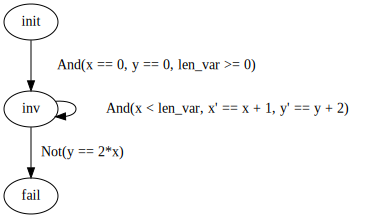

In [42]:
def mk_cfa3():
    A = CFA('prog')
    x, x_out = A.add_var(z3.IntSort(), name='x')
    y, y_out = A.add_var(z3.IntSort(), name='y')
    l, l_out = A.add_var(z3.IntSort(), name='len_var')
    A.set_entry_node('init')
    A.set_exit_node('fail')
    
    A.add_edge('init', 'inv', z3.And(x == 0, y == 0, l >= 0))
    A.add_edge('inv', 'inv', And(x < l, x_out == x + 1, y_out == y + 2))
    A.add_assert('inv', z3.Not(y == 2*x))

    return A

cfa3 = mk_cfa3()
cfa3.to_dot()

In [43]:
def mk_challenge_3():
    T = Ts('Ts0')
    x, x_out = T.add_var(z3.IntSort(), name='x')
    y, y_out = T.add_var(z3.IntSort(), name='y')
    l, l_out = T.add_var(z3.IntSort(), name='l')
    T.Init = And(x == 0, y == 0, l >= 0)
    T.Tr = And(x < l, l_out == l, x_out == x + 1, y_out == y + 2)
    T.Bad = And(y != 2 * x)
    return T


In [44]:
from z3 import *

x = Int('x')
x1 = Int('x1')
y = Int('y')
y1 = Int('y1')
l = Int('len')

inv = Function('inv', IntSort(), IntSort(), IntSort(), BoolSort())
fail = Function('fail', BoolSort())

# Rule 1
rule1 = Implies(And(x == 0, y == 0, l >= 0), inv(x, y, l))

# Rule 2
rule2 = Implies(
    And(inv(x, y, l), x < l, x1 == x + 1, y1 == y + 2),
    inv(x1, y1, l)
)

# Rule 3
rule3 = Implies(And(inv(x, y, l), y != 2 * x), fail())

# Create solver and add rules
solver = Solver()
solver.add(rule1, rule2, rule3)

# Query for fail and print the certificate
solver.add(fail())
print(solver.check())
print(solver.model())


sat
[y = 1,
 x = -2,
 fail = True,
 len = -1,
 y1 = 4,
 x1 = 0,
 inv = [else -> False]]


In [45]:
ts_challenge_3 = mk_challenge_3()
HtmlStr(ts_challenge_3)

"Transition System: Ts0<br/>\tInit: And(x == 0, y == 0, l >= 0)<br/>\tBad: And(y != 2*x)<br/>\tTr: And(x < l, l' == l, x' == x + 1, y' == y + 2)"

In [46]:
def vc_challenge_3(T):
    Inv = z3.Function('Inv', *(T.sig() + [z3.BoolSort()]))

    InvPre = Inv(*T.pre_vars())
    InvPost = Inv(*T.post_vars())

    all_vars = T.all()
    vc_init = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Tr), InvPost))
    vc_bad = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))
    return [vc_init, vc_ind, vc_bad], InvPre

vc_challenge_3, inv_challenge_3 = vc_challenge_3(ts_challenge_3)
res_challenge_3, answer_challenge_3 = solve_horn(vc_challenge_3, max_unfold=40)
res_challenge_3


sat

In [47]:
print(answer_challenge_3)

[Inv = [else ->
        And(Not(2*Var(0) + -1*Var(1) <= -1),
            Not(2*Var(0) + -1*Var(1) >= 1))]]


### Answer

In [48]:
asw_ch_3 = answer_challenge_3.eval(inv_challenge_3)
push_not(asw_ch_3)

And(2*x >= y, 2*x <= y)

In [49]:
print(push_not(asw_ch_3).sexpr())

(and (>= (+ (* 2 x)) (+ y)) (<= (+ (* 2 x)) (+ y)))


### Z3 validator

In [50]:
from z3 import *

# Declare the relations
Inv = Function('Inv', IntSort(), IntSort(), BoolSort())
Fail = Bool('Fail')

N = 1351234
M = N * 2

# Declare the variables
x0 = Int('x0')
x1 = Int('x1')
y0 = Int('y0')
y1 = Int('y1')

# Initialize the solver
s = Solver()

# Define the rules
# Rule 1
s.add(ForAll([x0, y0], Implies(And(x0 == 0, y0 == 0), Inv(x0, y0))))

# Rule 2
s.add(ForAll([x0, y0, x1, y1], 
              Implies(And(Inv(x0, y0), x0 >= 2*y0, x1 == x0 + 1, y1 == If(x0 % 2 == 0, y0 + 1, y0)), 
                      Inv(x1, y1))))

# Rule 3
s.add(ForAll([x0, y0], 
              Implies(And(Inv(x0, y0), x0 == M, y0 != N), 
                      Fail)))

s.check()


sat

In [51]:
from z3 import *
import sys

def solution_checker(s, error_msg):
    if s.check() != sat:
        print(error_msg)
        sys.exit()

# Declare the variables
x, y = Ints('x y')
x0, y0 = Ints('x0 y0')
x1, y1 = Ints('x1 y1')

N = 1351234
M = N * 2

# Your solution
solution = And(Implies(x % 2 == 1, x <= (2 * y) - 1),
               N >= y,
               M >= x,
               x <= 2*y)

# Base case
base_case = And(x0 == 0, y0 == 0)

# Inductive step
inductive_step = And(x1 == x0 + 1, y1 == If(x0 % 2 == 0, y0 + 1, y0))

# Failsafe
failsafe = And(x0 == M, y0 != N)

# Initialize solver
s = Solver()

# Base case
s.add(Implies(base_case, substitute(solution, [(x, x0), (y, y0)])))
solution_checker(s, "Base case failed")

# Inductive step
s.reset()
solution_prime = substitute(solution, [(x, x1), (y, y1)])
s.add(ForAll([x0, y0, x1, y1], Implies(And(solution, inductive_step), solution_prime)))
solution_checker(s, "Inductive step failed")

# Failsafe
s.reset()
s.add(ForAll([x0, y0], Implies(And(solution, failsafe), False)))
solution_checker(s, "Failsafe failed")

print("Solution is inductive over the original problem")


Solution is inductive over the original problem
